# FORESEE Models: ALP - Light Shining Through the Wall

Analysis reproducing the results from [arXiv:2204.03599](https://arxiv.org/abs/2204.03599): *Axion Searches at the LHC: FASER as a Light Shining through Walls Experiment*

### Load Libraries

In [1]:
import sys, os
src_path = "../../"
sys.path.append(src_path)

import numpy as np
import random, math, types
from skhep.math.vectors import LorentzVector, Vector3D
from src.foresee import Foresee, Utility, Model
from matplotlib import pyplot as plt

## 1. Specifying the Model and Setup

**Model:** The phenomenology of the ALP can be described by the following Lagrangian

\begin{equation}
 \mathcal{L} = - \frac{1}{2} \color{red}{m_{a}}^2 a^2  - \frac{\color{red}{g}}{4}a F^a_{\mu\nu} \tilde F^a_{\mu\nu}
\end{equation}

with the ALP mass $m_a$ and the coupling parameter $g$ as free parameters. 

**Process:** Unlike most other physics models at FASER, here we are not the decay of an ALP inside the FASER decay volume but its conversion in FASER's magnetic field. For this, let us note that we can rewrite the ALP coupling as $a F^a_{\mu\nu} \tilde F^a_{\mu\nu} \sim a \vec{E} \cdot \vec{B}$, so as a coupling between the ALP, an electric field and a magnetic field. This means that in the presence of an external magnetic field a photon can convert into an ALP and vice versa. Her can use this effect twice: once to convert an LHC photon inside the forward LHC magnets  into an ALP, and once to convert the ALP back into a photon in inside the FASER magnet. The signature is therefore a single high-energy photon appearing inside the FASER detector.   

Since this process is very specific to this particular mode, we are directly providing the code below, and only rarely make use of the FORESEE functionaties. 

### a) Load Photons

First, let us initiate FORESEE and load the LHC photons into a numpy array labeled `photons`. In the following, we model the production using `EPOSLHC`, `SIBYLL`, `QGSJET`, and `Pythia8-Forward`. 

In [2]:
foresee = Foresee(path=src_path)

energy = "13.6"
generators=['EPOSLHC', 'SIBYLL', 'QGSJET', 'Pythia8-Forward']
modelname="ALP-LSW"
nsample=10

filename = [foresee.dirpath + "files/hadrons/"+energy+"TeV/"+gen+"/"+gen+"_"+energy+"TeV_22.txt" for gen in generators]
photons = foresee.convert_list_to_momenta(filename,mass=0, nsample=nsample)

### b) Define Fields

Next, we define the magnetic fields. Here *dipole* magnets are defined by a constant magnetic field $B$ while *quadrupole* magnets are defined by a field gradient $B'$. For FASER, FASER2, the LHC and the HL-LHC we specify

- the type of magnet (`q` for quadrupole and `d` for dipole)
- the starting position `z` in meters
- the length `L` in meters
- the strength `B` in Tesla (for dipoles) or gradient `B'` in Tesla/meter (for quadrupoles)

The LHC configuration is taken from Ref. [2105.08270](https://arxiv.org/abs/2105.08270), while the HL-LHC configuration is taken from [HL-LHC TDR](https://cds.cern.ch/record/2749422/) . 

In [3]:
magnets = {
    "FASER": [
        ["d", 0   , 1.5 , 0.576  ],
        ["d", 1.7 , 1.0 , 0.576  ],
        ["d", 2.9 , 1.0 , 0.576  ],
    ],
    "FASER2": [
        ["d", 0   , 20  , 1    ],
    ],
    "LHC-14TeV": [
        ["q", 22.9, 6.37, 188.6], 
        ["d", 30. , 1   , 1.5  ],
        ["q", 32  , 5.5 , 191. ],
        ["d", 38. , 1   , 1.5  ],
        ["q", 39  , 5.5 , 191  ],
        ["q", 46.9, 6.37, 188.6],
        ["d", 53.5, 1   , 1.5  ],
        ["d", 60. , 20. , 1.28 ],
    ],
    "LHC-13.6TeV": [
        ['q', 22.965, 6.37,  197.6983],
        ['v', 29.845, 0.1 ,  1.28    ],
        ['q', 32.050, 5.5 , -198.8156],
        ['v', 38.019, 0.1 ,  1.28    ],
        ['q', 38.550, 5.5 , -198.8156],
        ['q', 46.965, 6.37,  199.0995],
        ['v', 53.814, 0.1 ,  1.28    ],
        ['d', 59.622, 3.4 , -1.242   ],
        ['d', 63.888, 3.4 , -1.242   ],
        ['d', 68.154, 3.4 , -1.242   ],
        ['d', 72.42 , 3.4 , -1.242   ],
        ['d', 76.686, 3.4 , -1.242   ],
        ['d', 80.952, 3.4 , -1.242   ],
    ],
    "HLLHC": [
        ["q", 22.9, 8.4 ,132. ],
        ["d", 34  , 1.  ,2.5  ],
        ["q", 35  , 7.17,132. ],
        ["q", 45  , 7.17,132. ],
        ["d", 53  , 1   ,2.5  ],
        ["q", 56. , 8.4 ,132. ],
        ["d", 68  , 1   ,4.5  ],
        ["d", 72. , 6.27,5.6  ],
    ],
}

### c) Simple back-on-the envelope estimate

We can already perform a vary simple back-on-the envelope estimate by only using the D1 magnet (which provides the dominant contribution) and assuming the small mass limit (so $qL\ll1$). 

The $\gamma \to a$ coonversion probability in a magnetic field $B_1$ of length $L_1$ is approximately
\begin{equation}
P(\gamma \to a) = \frac{1}{2} \times \frac{1}{4} g^2 \left| \int dz \ B_1(x) \ e^{i q z} \right|^2 = \frac{1}{8} g^2 B_1^2 L_1^2 \left(\frac{\sin(qL_1/2)}{qL_1/2}\right)^2 \approx  \frac{1}{8} g^2 B_1^2 L_1^2
\end{equation}
Here  the  additional factor 1/2 in front accounts for the fact that the photon beam is unpolarized and only the photons with a polarization parallel to the magnetic field can convert into ALPs. 

The $a \to \gamma$ coonversion probability in a magnetic field $B_2$ of length $L_2$ is approximately
\begin{equation}
P(a \to \gamma) = \frac{1}{4} g^2 \left| \int dz \ B_2(x) \ e^{i q z} \right|^2 = \frac{1}{4} g^2 B_2^2 L_2^2 \left(\frac{\sin(qL_2/2)}{qL_2/2}\right)^2 \approx  \frac{1}{4} g^2 B_2^2 L_2^2
\end{equation}

So the total event rate $N$ is
\begin{equation}
N = (g \cdot GeV)^4 \times (B_1/T)^2 \times (L_1/m)^2 \times (B_2/T)^2 \times (L_2/m)^2 \times N_\gamma
\end{equation}
where $N_\gamma$ is the number of incoming photons. Here we used that Tm/GeV $\approx 1$. 

The function below provides the coupling reach requireing 3 signal events. For this we need: 
- the number of photons `n0`
- the B-field of the D1 magnet `b1`
- the length of the D1 magnet `l1`
- the B-field of the FASER magnet `b2`
- the length of the FASER magnet `l2`

In [4]:
def back_on_envelope_estimate(n0=2e15, b1=1.28, l1=20, b2=0.6, l2=3.5):
    nevent =  n0 * 1./32. * b1**2 * b2**2 * l1**2 * l2**2
    return (3./nevent)**(0.25)

print ("The LHC reach is g="   +str( back_on_envelope_estimate(n0=2e15, b1=1.28, l1=20  , b2=0.6, l2=3.5)))
print ("The HL-LHC reach is g="+str( back_on_envelope_estimate(n0=6e17, b1=5.6 , l1=6.27, b2=1  , l2=20 )))

The LHC reach is g=6.383820680520338e-05
The HL-LHC reach is g=4.244115691225136e-06


### d) Production and Detection Probabilities

The conversion probability in a magnetic field has been derived in [2203.06137](https://arxiv.org/abs/2203.06137). For **axion to photon converison** we can write

\begin{equation}
P(a \to \gamma) = \frac{1}{4} g^2 \left| \int dz \ B(x) \ e^{i q z} \right|^2 = \frac{1}{4} g^2 B^2 L^2 \left(\frac{\sin(qL/2)}{qL/2}\right)^2
\end{equation}

Here we explicitly used that the FASER magnets are homogeneous, which results in linearly polarized photons in the detector. For **photon to axion converison** it is given by

\begin{equation}
P(\gamma \to a) = \frac{1}{n_\text{pol} }\sum_\text{pol}\frac{1}{4} g^2 \left| \int dz \ e^{i q z} \ \vec{B}(z)\cdot  \vec{p}   \right|^2 = \frac{g^2}{8}  \left( \left| \int dz \ B_x(z) \ e^{i q z} \right|^2 + \left| \int dz \ B_y(z)  \ e^{i q z} \right|^2 \right) 
\end{equation}

Here $p$ denotes the polarization vectors, which we have written in terms of a linear polariztaion basis. To simplify the expression we can use that the fields are (to a good approximation) piecewise constant along the trajectory of a photon and therefore write

\begin{equation}
 \int dz B(z) e^{i q z}  =  \sum_i B_i \times \left[ \frac{e^{iqz}}{iq} \right]^{z_i+L_i}_{z_i} =   \sum_i B_i \times \frac{e^{iq(z_i+L_i)}-e^{iqz_i}}{iq} =   \sum_i B_i L_i \times e^{iq(z_i+L_i/2)}\frac{e^{iqL_i/2}-e^{-iqL_i/2}}{2i qL_i/2} = \sum_i B_i L_i \times e^{iq(z_i+L_i/2)}\frac{\sin(q L_i /2)}{qL_i/2} 
\end{equation}

So we can write 

\begin{equation}
P(\gamma \to a) = \frac{g^2}{8}  \left( \left|  \sum_i B_{x,i} L_i \times e^{iq(z_i+L_i/2)}\frac{\sin(q L_i /2)}{qL_i/2}  \right|^2 + \left|  \sum_i B_{y,i} L_i \times e^{iq(z_i+L_i/2)}\frac{\sin(q L_i /2)}{qL_i/2}  \right|^2 \right) 
\end{equation}

In addition, we can use also the **Primakoff conversion in production**. Following [1806.02348](https://arxiv.org/abs/1806.02348) and for very small $m_a$, we get

\begin{equation}
P(\gamma \to a)_{Prim} = \sigma_{Prim}/\sigma_{SM} = 0.000737 \times g^2 \quad \text{where} \quad \sigma_{Prim} = \frac{1}{4} g^2 \alpha Z^2 \times \frac12 \int F^2(t)  d\log t
\end{equation}

Below we provide the exact Primakoff conversion probability factor as `get_conversion_factor()` function. 

In [5]:
def get_conversion_factor(tmin=1e-20):
    if tmin < 1e-12: return 0.00073736306
    alpha, me, ZFe, AFe = 1./137., foresee.masses('11'), 26, 56
    a, d  = 111.*ZFe**(-1./3.) / me,  0.164 * AFe**(-2./3.)
    SMXSinIGeV2 = 13311.9696379 
    logtmin, logtmax, nlogt = np.log10(tmin), 0, 20
    dlogt = (logtmax-logtmin)/float(nlogt)
    xs=0
    for lt in np.linspace(logtmin+0.5*dlogt,logtmax-0.5*dlogt,nlogt):
        t = 10**lt
        if t<7.39*me*me: ff = a*a*t/(1.+a*a*t)
        else: ff = 1./(1.+t/d)
        xs += alpha * ZFe**2 / 4. * 0.5 * ff**2  * dlogt * np.log(10) 
    return xs / SMXSinIGeV2 

print (get_conversion_factor(tmin=0.00000000001))

0.0007373185720777062


We could also have $a \to \gamma$ conversion via the **inverse Primakoff process** occuring inside a medium (so axion scattering). The probability is given by $P(a \to \gamma)_{Prim} = 1/(\sigma_{prim} n L) = 0.03 \times g^2$ for a 7m long LAr detector. Below, we provide a function that estimates the conversion probability in FLArE

In [6]:
def get_interaction_flare(tmin=1e-15, tmax=1):
    #shortcut
    if tmin<1e-12: return 0.02837736181362896
    #matter properties
    ZFe, AFe, rhoFe, lenFe = 18, 40, 1.4, 700 #FLArE LAr
    #get xs in cm2
    mproton = foresee.masses('2212')*1.782661921e-24 # converted from GeV to grams
    alpha, me = 1./137., foresee.masses('11')
    a, d  = 111.*ZFe**(-1./3.) / me,  0.164 * AFe**(-2./3.)
    GeV_CM = 0.2e-13
    logtmin, logtmax, nlogt = np.log10(tmin), np.log10(tmax), 50
    dlogt = (logtmax-logtmin)/float(nlogt)
    xs=0
    for lt in np.linspace(logtmin+0.5*dlogt,logtmax-0.5*dlogt,nlogt):
        t = 10**lt
        if t<7.39*me*me: ff = a*a*t/(1.+a*a*t)
        else: ff = 1./(1.+t/d)
        xs += alpha * ZFe**2 / 4. * 0.5 * ff**2  * dlogt * np.log(10) 
    xscm2 = xs * GeV_CM**2 
    # number density
    ndensity = rhoFe / (AFe*mproton)
    #get mean free path
    mfp = 1 / xscm2 / ndensity
    # probability
    prob = lenFe / mfp
    return prob

tmin = 1e-9**4/(2*1000**2)
print (get_interaction_flare(tmin=tmin))

0.02837736181362896


### e) Event Rate Calculation

Now that we have all the ingredients, we can combine them and estimate the number of events in FASER. This is done by the function `get_nevent()` which returns set of couplings and the corresponding number of events. 

In [7]:
def get_nevent(
        mass,
        couplings = np.logspace(-6,0,30+1),
        lumi=150,
        selection = "np.sqrt(x.x**2 + x.y**2)<.1",
        distance=480,
        magnets_production=None,
        magnets_interaction=None,
        production_prim=False,  
        production_conv=True, 
        interaction_prim=False, 
        interaction_conv=True,
        xing_urad_vertical=0,
        xing_urad_horizontal=0,
        efficiency=1,
    ):
    
    #lumi ifb > ipb
    lumi*=1000
    
    #decay width
    gamma = mass**3/(64*3.1415)
    ctau = 0.2e-15/gamma
    
    # constants:
    t_m_igev, m_gev, radius_pipe = 1, 5e15, 0.0265
    z_tas, radius_tas = 22, 0.017
    
    # efficiency
    efficiency_tpye = type(efficiency)

    # loop over particles
    nvals = [0 for g in couplings]
    stat_p, stat_w = [[] for g in couplings], [[] for g in couplings]
    for momentum, weight in zip(photons[0],photons[1]):
        
        # preselection
        if momentum.theta() > 0.001 or momentum.e < 100: continue
        
        # xing angle
        if xing_urad_vertical != 0:
            angle = xing_urad_vertical/1000./1000. 
            momentum = LorentzVector(
                momentum.x, 
                momentum.y*np.cos(angle)+momentum.z*np.sin(angle), 
                momentum.z*np.cos(angle)-momentum.y*np.sin(angle),
                momentum.e
            )
        if xing_urad_horizontal != 0:
            angle = xing_urad_horizontal/1000./1000. ;
            momentum = LorentzVector(
                momentum.x*np.cos(angle)+momentum.z*np.sin(angle), 
                momentum.y, 
                momentum.z*np.cos(angle)-momentum.x*np.sin(angle),
                momentum.e
            )
            
        #kinematics
        th, en, phi = momentum.theta(), momentum.e, momentum.phi()
        q = mass**2/en 
        
        #select events in experimental coverage
        x=float(distance/momentum.z)*momentum
        if type(x) is np.ndarray: x=Vector3D(x[0],x[1],x[2])
        if eval(selection)==False: continue
            
        # efficiency
        energy, eff = momentum.p, 1
        if efficiency_tpye==str: eff = eval(efficiency)
        elif efficiency_tpye==float: eff = efficiency
        elif efficiency_tpye==int: eff = efficiency
        elif efficiency_tpye==types.FunctionType: eff = efficiency(energy)
        
        #prob production
        prob_p = 0
        if production_conv:
            integralx, integraly = 0, 0
            for mag, z, l, field in magnets_production:
                if z_tas*th > radius_tas: continue
                if z*th > radius_pipe: continue
                if   mag == "d": bx,by = 0, field
                elif mag == "v": bx,by = field, 0
                elif mag == "q": bx, by = th * z * np.cos(phi) * field, th * z * np.sin(phi) * field
                ql=q*l*m_gev
                integralx += bx *  t_m_igev  * l * np.exp(-1.J*q*(z+l/2.)*m_gev)* np.sin(ql/2.)/(ql/2.) 
                integraly += by *  t_m_igev  * l * np.exp(-1.J*q*(z+l/2.)*m_gev)* np.sin(ql/2.)/(ql/2.) 
            prob_p += 1./8. *(abs(integralx)**2+abs(integraly)**2)
        
        #primakoff production
        if production_prim:
            if en>1: prob_p+=get_conversion_factor(tmin=mass**4/(2*en**2) )
        
        #prob detection
        prob_d=0
        if interaction_conv:
            integral = 0
            for mag, z, l, field in magnets_interaction:
                if mag == "d": b = field
                else: continue
                ql=q*l*m_gev
                integral += b *  t_m_igev  * l * np.exp(-1.J*q*(z+l/2.)*m_gev)* np.sin(ql/2.)/(ql/2.) 
            prob_d += 1./4. *abs(integral)**2
            
        # primakoff detection
        if interaction_prim: 
            prob_d += get_interaction_flare(tmin=mass**4/(2*en**2) )
            
        # lifetime
        dbar = ctau*en/mass
        
        # count event rate
        dnevent = weight * lumi * prob_p * prob_d
        for ig, g in enumerate(couplings): 
            prob_notdecay = 1 if mass<1e-4 else np.exp(-(distance-140)/dbar*g**2)
            nvals[ig] += g**4 * dnevent * prob_notdecay * eff
            stat_p[ig].append(momentum)
            stat_w[ig].append(g**4 * dnevent * prob_notdecay * eff)

    return couplings, np.array(nvals), stat_p, np.array(stat_w)

### f) Function to Export Events

We can also write some events as a HEPMC file.

In [8]:
def write_events(
        mass, 
        coupling,  
        lumi=150,
        selection = "np.sqrt(x.x**2 + x.y**2)<.1",
        distance=480,      
        magnets_production=None,
        magnets_interaction=None,  
        production_prim=False,  
        production_conv=True, 
        interaction_prim=False, 
        interaction_conv=True,  
        filename=None, 
        numberevent=10, 
        zposition=0, 
        seed=None, 
        return_data=False,
        xing_urad_vertical=0,
        xing_urad_horizontal=0,
        efficiency=1,
    ):
          
    #set random seed
    random.seed(seed)
        
    # get weighted sample of LLPs
    _,_, weighted_raw_data, weights = get_nevent(
        mass=mass, 
        couplings = [coupling],
        lumi=lumi,
        selection=selection,
        distance=distance,
        magnets_production=magnets_production,
        magnets_interaction=magnets_interaction,
        production_prim=production_prim,
        production_conv=production_conv,
        interaction_prim=interaction_prim,
        interaction_conv=interaction_conv,
        xing_urad_vertical=xing_urad_vertical,
        xing_urad_horizontal=xing_urad_horizontal,
        efficiency=efficiency,
    )
    
    # process 
    weighted_data = [[p,0 if w[0]==0 else w/w[0]] for p,w in zip(weighted_raw_data[0], weights[0])]
    baseweights = weights[0].T[0]
    
    # unweight sample 
    unweighted_raw_data = random.choices(weighted_data, weights=baseweights, k=numberevent)
    eventweight = sum(baseweights)/float(numberevent)
        
    # get photon momenta and decay location
    unweighted_data = []
    for momentum_gamma, weight in unweighted_raw_data:
        # momentum ALP
        phi = momentum_gamma.phi()
        theta = momentum_gamma.theta()
        en = momentum_gamma.e
        mom = np.sqrt(en**2-mass**2)
        pz, pt = mom*np.cos(theta), mom*np.sin(theta)
        px, py = pt*np.cos(phi), pt*np.sin(phi)
        momentum_alp = LorentzVector(px,py,pz,en)
        # position
        posz = zposition
        posx = theta*distance*np.cos(phi)
        posy = theta*distance*np.sin(phi)
        position = LorentzVector(posx,posy,posz,0)
        # save
        unweighted_data.append([eventweight*weight, position, momentum_alp, [22], [momentum_gamma] ])
        
    # set output filename
    dirname = "model/events/"
    if not os.path.exists(dirname): os.mkdir(dirname)
    if filename==None: filename = dirname+str(mass)+"_"+str(coupling)+".hepmc"
          
    # write to HEPMC file
    foresee.write_hepmc_file(filename=filename, data=unweighted_data, weightnames=generators)
    
    #return
    if return_data: return weighted_raw_data[0], weights[0], unweighted_raw_data

## 2. Event Generation

In the following, we want to study one specific benchmark point with $m_{a}=1$ eV and $g=3\cdot 10^{-5}$ and export events as a HEPMC file. 

In [9]:
mass, coupling, = 1e-9, 1e-4

Let us now specify the detector setup. Here we choose FASER during 2022/2023. 

In [10]:
lumi, distance = 60, 474
selection = "np.sqrt(x.x**2 + (x.y+0.012)**2)<.1"
magnets_production = magnets["LHC-13.6TeV"]
magnets_interaction = magnets["FASER"]
xing_urad_vertical=-160
xing_urad_horizontal=0

For our benchmark point, let us now look at how many particle decay inside the decay volume. We also export 1000 unweighted events as a HEPMC file. 

In [11]:
momenta, weights, _ = write_events(
    mass=mass, 
    coupling=coupling, 
    lumi=lumi,
    distance=distance, 
    selection = selection,
    magnets_production=magnets_production,
    magnets_interaction=magnets_interaction,
    xing_urad_vertical=xing_urad_vertical,
    xing_urad_horizontal=xing_urad_horizontal,
    numberevent = 1000,
    filename = "model/events/test.hepmc", 
    return_data = True,
)

for isetup, setup in enumerate(generators):
    print("Expected number of events for "+setup+":", round(sum(weights[:,isetup]),5))

Expected number of events for EPOSLHC: 7.69622
Expected number of events for SIBYLL: 6.97761
Expected number of events for QGSJET: 7.06489
Expected number of events for Pythia8-Forward: 7.34969


Let us plot the resulting energy distribution

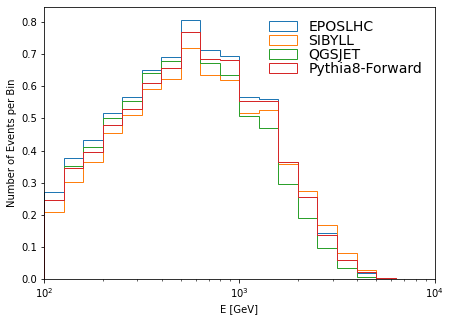

In [12]:
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(1,1,1)
energies = [p.e for p in momenta], 
for isetup, setup in enumerate(generators):
    ax.hist(energies, weights=weights[:,isetup], bins=np.logspace(2,4, 20+1), histtype='step', label=setup) 
ax.set_xscale("log")
ax.set_xlim(1e2,1e4) 
ax.set_xlabel("E [GeV]") 
ax.set_ylabel("Number of Events per Bin") 
ax.legend(frameon=False, labelspacing=0, fontsize=14)
plt.show()

## 3. Sensitivity Reach

In the following, we will obtain the projected sensitivity for the model. For this, we first define a grid of couplings and masses. 

In [13]:
masses = np.logspace(-15, 0, 30+1)
couplings = np.logspace(-6, 0, 40+1) 

Let us now scan over various masses and couplings, and record the resulting number of events. Note that here we again consider the FASER configuration, which we set up before.

In [14]:
#get reach  
list_nevents = {label:[] for label in generators}
for mass in masses:
    _, nevents, _, _  = get_nevent(
        mass=mass, couplings=couplings, 
        lumi=lumi, distance=distance, selection=selection, 
        magnets_production=magnets_production, magnets_interaction=magnets_interaction,
        xing_urad_vertical=xing_urad_vertical,xing_urad_horizontal=xing_urad_horizontal,
    )
    for i,label in enumerate(generators): list_nevents[label].append(nevents.T[i])  
    
#save results
if not os.path.exists("model/results"): os.mkdir("model/results")
configuration='default'
for label in generators: 
    result = np.array([masses*1e9,couplings,list_nevents[label]], dtype='object')
    np.save("model/results/"+energy+"TeV_"+configuration+"_"+label+".npy",result)

We can now plot the results. To use FORESEE's plotting functions, we first initialize a FORSEE model. 

In [15]:
model = Model("ALP-LSW")
foresee.set_model(model=model)

We then specify all detector setups for which we want to show result (filename in model/results directory, label, color, linestyle, opacity alpha for filled contours, required number of events).

In [16]:
setups = [ 
    ["13.6TeV_default_EPOSLHC.npy",         "EPOSLHC", "red"        ,  "solid"  , 0., 3],
    ["13.6TeV_default_SIBYLL.npy" ,         "SYBILL" , "magenta"    ,  "solid"  , 0., 3],
    ["13.6TeV_default_QGSJET.npy" ,         "QGSJET" , "orange"     ,  "solid"  , 0., 3],
    ["13.6TeV_default_Pythia8-Forward.npy" ,"PYTHIA" , "firebrick"  ,  "solid"  , 0., 3],
]

Then we specify all the existing bounds (filename in model/bounds directory, label, label position x, label position y, label rotation). 

In [17]:
bounds = [
    ["bounds_Belle2.txt"  , ""                     , 0.210 , 1.5e-3, 0 ],
    ["bounds_PrimEx.txt"  , ""                     , 0.126 , 1.2e-3, 0 ],
    ["bounds_BaBar.txt"   , "BaBar"                , 4e2   , 2e-4  , 0 ],
    ["bounds_BeamDump.txt", "Beam\nDump"           , 2e4   , 6e-4  , 0 ],
    ["bounds_Nomad.txt"   , "Nomad"                , 3e-2  , 2e-4  , 0 ],
    ["bounds_PVLAS.txt"   , "PVLAS"                , 4e-3  , 7e-6, 90 ],
    ["bounds_ALPS.txt"    , "ALPS"                 , 2e-3  , 7e-6, 90 ],
    ["bounds_Upsilon.txt" , r"BaBar $\Upsilon$"    , 0.126 , 1.5e-3, 0 ],       
]

We then specify other projected sensitivitities (filename in model/bounds directory, color, label, label position x, label position y, label rotation) **ADD OTHER PROPOSED SEARCHES FROM PAPER** 

In [18]:
projections = [
    ["limits_FLARE.txt"  ,  "blue"         ,r"FLARE"  , 0.02, 1.00*10**-5, 0  ],
]

We then specify other projected sensitivitities (filename in model/bounds directory, color, label, label position x, label position y, label rotation)

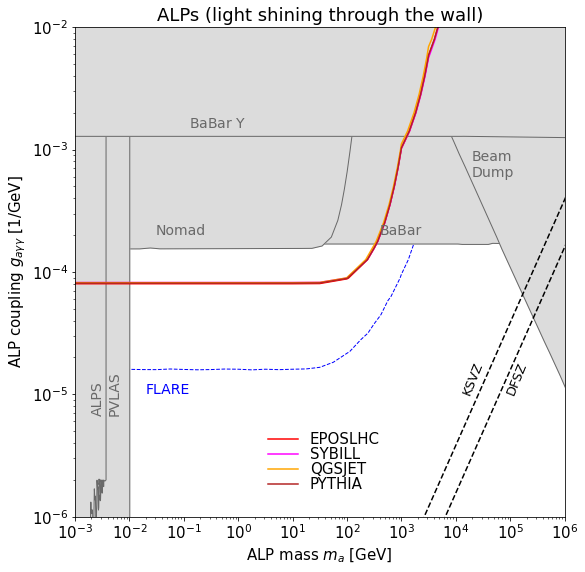

In [19]:
plot = foresee.plot_reach(
    setups=setups,
    bounds=bounds,
    projections=projections,
    title="ALPs (light shining through the wall)", 
    xlims=[1e-3,1e+6], 
    ylims=[1e-6,1e-2],
    xlabel=r"ALP mass $m_{a}$ [GeV]", 
    ylabel=r"ALP coupling $g_{a\gamma\gamma}$ [1/GeV]",
    legendloc=(0.65,0.2),
    figsize=(8,8),
)

# QCD Axion Target Lines
DFSZ = np.array([[0.00677, 1e-12], [31136768., 0.005]])
plot.plot(DFSZ.T[0], DFSZ.T[1], color="k", lw=1.5, ls="dashed")        
plot.text(8e4, 1e-5, "DFSZ",fontsize=13, color="k",rotation=68)
KSVZ = np.array([[0.00277, 1e-12], [12761133., 0.005]])
plot.plot(KSVZ.T[0], KSVZ.T[1], color="k", lw=1.5, ls="dashed")  
plot.text(1.2e4, 1e-5, "KSVZ",fontsize=13, color="k",rotation=68)

plot.subplots_adjust(left=0.12, right=0.97, bottom=0.10, top=0.95)
plot.savefig("Reach_"+modelname+".pdf")
plot.show()